### CORONA VIRUS: data preparation notebook

- download : https://nuage.lip6.fr/s/XnbmSioDxnw4wbn
- move corona_research.zip into data subdirectory
- unzip corona_research.zip


## Import

#### Import for spark

In [79]:
import findspark
findspark.init()
from pyspark.sql import *
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.sql.types import *
import time

#### Import for visualization

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn as sns

from graphviz import *

from IPython.display import display, HTML

#### Import needed for interaction

In [81]:
# interaction
# from __future__ import print_function
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

#### Start spark engine

In [82]:
#spark.stop()

local = "local[*]"
appName = "Essai graph spark"
memory="8G"

configLocale = SparkConf().setAppName(appName).setMaster(local).\
set("spark.executor.memory", memory).\
set("spark.driver.memory", memory).\
set("spark.sql.catalogImplementation","in-memory")
spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

print("Spark application id is:", sc.applicationId)

Spark application id is: local-1587806464498


## Datasets

In [83]:
DATA_ROOT = "data"
#DATA_DIR = DATA_ROOT + "/wiley/"
# DATA_DIR = DATA_ROOT + "/glyphosate/"
#DATA_DIR = DATA_ROOT + "/istex/"
DATA_DIR = DATA_ROOT + "/corona_research/"

print('DATA-DIR:' + DATA_DIR)

DATA-DIR:data/corona_research/


#### Similarity links

In [84]:
# similarityLinks = spark.read.json(DATA_DIR + 'similarityLinks')
# new version : format = parquet
similarityLinks = spark.read.parquet(DATA_DIR + 'similarityLinks')
similarityLinks.show(5, False)

+--------+--------+---------------------+
|idTopic1|idTopic2|similarity           |
+--------+--------+---------------------+
|839     |880     |0.012104837348399297 |
|35      |811     |0.011137929816773369 |
|715     |729     |0.0015759191419612594|
|499     |658     |0.020800887859958577 |
|72      |660     |0.017831831355573362 |
+--------+--------+---------------------+
only showing top 5 rows



#### Topic nodes

In [85]:
#topicNodes = spark.read.json(DATA_DIR + 'topicNodes')
topicNodes = spark.read.parquet(DATA_DIR + 'topicNodes')
# topicNodes.show(1, False)
topicNodes.orderBy("idTopic", desc("weight")).show(20, False)

+---------+-------+------------+------+--------------------+
|period   |idTopic|localTopicId|term  |weight              |
+---------+-------+------------+------+--------------------+
|2000-2002|0      |0           |333341|0.03103907018850856 |
|2000-2002|0      |0           |418514|0.024622404030789437|
|2000-2002|0      |0           |206315|0.022136176498808877|
|2000-2002|0      |0           |339290|0.018724624790095904|
|2000-2002|0      |0           |417117|0.017136302308375567|
|2000-2002|0      |0           |223229|0.015532057286507016|
|2000-2002|0      |0           |417118|0.014697545182749917|
|2000-2002|0      |0           |198585|0.012795234334577367|
|2000-2002|0      |0           |449065|0.012128006725685777|
|2000-2002|0      |0           |384592|0.009675856045232073|
|2000-2002|0      |0           |374402|0.009447154358364589|
|2000-2002|0      |0           |143141|0.009318930661139835|
|2000-2002|0      |0           |140700|0.008809365639452059|
|2000-2002|0      |0    

In [86]:
topicNodes.where("idTopic = 110").show(5, False)

+---------+-------+------------+------+--------------------+
|period   |idTopic|localTopicId|term  |weight              |
+---------+-------+------------+------+--------------------+
|2002-2004|110    |20          |201093|0.4280600868574067  |
|2002-2004|110    |20          |445615|0.08314983111477682 |
|2002-2004|110    |20          |327530|0.014378137011059805|
|2002-2004|110    |20          |169310|0.013071913393804516|
|2002-2004|110    |20          |5000  |0.013042181550731153|
+---------+-------+------------+------+--------------------+
only showing top 5 rows



#### Term dictionary (terms to display in the global graph)

In [87]:
# vocabularies = spark.read.json(DATA_DIR + 'wiley_CS_voc_199620153220')
# vocabularies = spark.read.json(DATA_DIR + 'GlyphosateWoS_voc_199420133230')
vocabularies = spark.read.parquet(DATA_DIR + 'corona_research_voc_200020203290')
vocabularies.show(5, False)

+------+-------------------------------+
|id    |term                           |
+------+-------------------------------+
|293200|intrahepatic cholestasis       |
|293234|intramuscular injection        |
|293242|intranasal DNA vaccine         |
|293253|intranasal budesonide          |
|293267|intranasal glucocorticosteroids|
+------+-------------------------------+
only showing top 5 rows



In [88]:
vocabularies.where("id = 293200").show()

+------+--------------------+
|    id|                term|
+------+--------------------+
|293200|intrahepatic chol...|
+------+--------------------+



#### topicDictionary_unique_10

In [89]:
# topicDictionary_unique_10 = spark.read.json(DATA_DIR + 'topicDictionary_unique_10')
# corona_research :
topicDictionary_unique_10 = spark.read.parquet(DATA_DIR + 'topicDictionary_unique_8')
topicDictionary_unique_10.show(2, False)
# topicDictionary_unique_10.groupBy().max("idTopic").show()

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|idTopic|topic                                                                                                                                                                                                                                                                |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|77     |[sudu, benda, agar, dapat, merusak, hal 1m rgantung dan J, N1la perbedaan tekanan ini semakin lama akan mengalam1 kena1kan karena debu yang mcnempel pada filter semakm tebal D

In [90]:
topicDictionary_unique_10.where("idTopic = 110").show(1, False)

+-------+----------------------------------------------------------------------------------------------------------------+
|idTopic|topic                                                                                                           |
+-------+----------------------------------------------------------------------------------------------------------------+
|110    |[deaths, suffering, metrisone, case fatality rate, 2003 2004, convalescent period, respiratory failure, methods]|
+-------+----------------------------------------------------------------------------------------------------------------+



#### evolutionPath

In [91]:
beta=0.5

nbTopicPerPeriod = 90

pivotDir = str(beta)+"_" + str(nbTopicPerPeriod) + "_0.0_8/"

# future = spark.read.json(DATA_DIR + '/evolutionPath/' + pivotDir + "future")
# past = spark.read.json(DATA_DIR + '/evolutionPath/' + pivotDir + "past")
# labels = spark.read.json(DATA_DIR + '/evolutionPath/' + pivotDir + "labels")

future = spark.read.parquet(DATA_DIR + '/evolutionPath/' + pivotDir + "future")
past = spark.read.parquet(DATA_DIR + '/evolutionPath/' + pivotDir + "past")
labels = spark.read.parquet(DATA_DIR + '/evolutionPath/' + pivotDir + "labels")


# future.show(1, False)
# past.show(1, False)
# labels.show(1, False)

In [92]:
future.printSchema()

root
 |-- Ti: long (nullable = true)
 |-- Pi: integer (nullable = true)
 |-- Tj: long (nullable = true)
 |-- Pj: integer (nullable = true)
 |-- Tk: long (nullable = true)
 |-- Pk: integer (nullable = true)
 |-- Beta: double (nullable = true)
 |-- Alpha: double (nullable = true)
 |-- localRank: integer (nullable = true)
 |-- TopicI: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- TopicJ: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- TopicK: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [93]:
#labels.printSchema()
labels.createOrReplaceTempView("labels")
print("done")

done


#### Metrics

In [94]:
# stats_future = spark.read.json(DATA_DIR + 'statistics_future')
stats_future = spark.read.parquet(DATA_DIR + 'statistics_future')

In [95]:
stats_future.printSchema()

root
 |-- TopicID: long (nullable = true)
 |-- Beta: double (nullable = true)
 |-- Startyear: integer (nullable = true)
 |-- Endyear: integer (nullable = true)
 |-- Liveliness: integer (nullable = true)
 |-- RelativeEvolutionDegree: double (nullable = true)
 |-- PivotEvolutionDegree: double (nullable = true)
 |-- SplitDegree: double (nullable = true)
 |-- ConvergenceDegree: double (nullable = true)
 |-- stable: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- emerging: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- decaying: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- specific: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [96]:
stats_future.show(3, False)

+-------+----+---------+-------+----------+-----------------------+--------------------+-----------+-----------------+------+-----------------------------------------------------------------------------------------+--------+--------------------------------------------------+
|TopicID|Beta|Startyear|Endyear|Liveliness|RelativeEvolutionDegree|PivotEvolutionDegree|SplitDegree|ConvergenceDegree|stable|emerging                                                                                 |decaying|specific                                          |
+-------+----+---------+-------+----------+-----------------------+--------------------+-----------+-----------------+------+-----------------------------------------------------------------------------------------+--------+--------------------------------------------------+
|30     |0.1 |2000     |2002   |9         |0.717                  |0.924               |2.665      |2.083            |[]    |[receptor, positive, sialic acid binding activi

#### Draw pivot graphs

##### Get the period list of the given corpus

In [97]:
periodList = topicNodes.select("period").distinct().orderBy("period").collect()
periodList

[Row(period='2000-2002'),
 Row(period='2002-2004'),
 Row(period='2004-2006'),
 Row(period='2006-2008'),
 Row(period='2008-2010'),
 Row(period='2010-2012'),
 Row(period='2012-2014'),
 Row(period='2014-2016'),
 Row(period='2016-2018'),
 Row(period='2018-2020')]

##### Define functions to draw pivot graphs by using Graphviz library

In [98]:
# define timeline graph funtion
def generateSVGSubgraphTimeline(graph, subgraph, periodList):
    pj = subgraph.select(col("Pj").alias("p"))
    pk = subgraph.select(col("Pk").alias("p"))
    p = pj.union(pk).distinct()
    
    # draw timeline
    # period nodes
    for periodId in p.collect():
        graph.node('P'+str(periodId.p), shape="plaintext", label=periodList[periodId[0]][0])
    
    # period edges
    edges = subgraph.select('Pj', 'Pk').distinct()
    for e in edges.collect():
        if (e.Pj < e.Pk):
            graph.edge('P'+str(e.Pj), 'P'+str(e.Pk))
        else:
            graph.edge('P'+str(e.Pk), 'P'+str(e.Pj))
            
    return graph

# g = Digraph('g2', format='png')
# graphTimeline = generateSVGSubgraphTimeline(g, subgraphFuture, periodList)
# graphTimeline


# label topics
def topicLabeling(graph, labels):
    for row in labels.select("Ti","stable", "emerging", "decaying", "specific").collect():
        label = "<table border=\"0\" cellspacing=\"0\">" + \
        "\n                    <tr><td border=\"1\">id:"+ str(row.Ti) + "</td></tr>" + \
        "\n                    <tr><td border=\"1\" bgcolor=\"deepskyblue\">"+ "<br/>".join(row.stable) + "</td></tr>" + \
        "\n                    <tr><td border=\"1\" bgcolor=\"green2\">"+ "<br/>".join(row.emerging) + "</td></tr>" + \
        "\n                    <tr><td border=\"1\" bgcolor=\"red2\">"+ "<br/>".join(row.decaying) + "</td></tr>" + \
        "\n                    <tr><td border=\"1\">"+"<br/>".join(row.specific) + "</td></tr>" +"\n                </table>"
        graph.node(str(row.Ti), shape="none", label="<" + label + ">")
    
    return graph


# align subnodes in pivot graph
def subgraphLabeling(graph, beta, periodList, timeDirection, subgraph, pivotLabels):
    # draw timeline
    graphTimeline = generateSVGSubgraphTimeline(graph, subgraph, periodList)
    
    parentsInPivotGraph = [ (x.Tj) for x in subgraph.select("Tj").distinct().collect()]
    childrenInPivotGraph = [ (x.Tk) for x in subgraph.select("Tk").distinct().collect()]
    topicsInPivotGraph = parentsInPivotGraph + childrenInPivotGraph
    subNodesLabels = pivotLabels.filter(col("Ti").isin(topicsInPivotGraph))
    graphTopicLabels = topicLabeling(graphTimeline, subNodesLabels)
    
    if (timeDirection == "future"):
      for e in subgraph.select( "Tj", "Tk", "Beta").distinct().collect():
        width = str((np.round(e.Beta, 2)-beta)*(10-1)/(1-beta)+1)
        graphTopicLabels.edge(str(e.Tj), str(e.Tk), penwidth=width, label=str(np.round(e.Beta, 2)), fontcolor='red')
    else:
      for e in subgraph.select( "Tk", "Tj", "Beta").distinct().collect():
        width = str((np.round(e.Beta, 2)-beta)*(10-1)/(1-beta)+1)
        graphTopicLabels.edge(str(e.Tk), str(e.Tj), penwidth=width, label=str(np.round(e.Beta, 2)), fontcolor='red')
    
    # align topic nodes {rank: same}
    
    return graphTopicLabels

# draw bidirectional pivot graph    
def bidirectionPivotGraph(graph, beta, periodList, subgraphFuture, subgraphPast, pivotLabels):
    # draw timeline
    graph1 = generateSVGSubgraphTimeline(graph, subgraphFuture, periodList)
    graph2 = generateSVGSubgraphTimeline(graph1, subgraphPast, periodList)
    
    parentsInPivotGraphFuture = [ (x.Tj) for x in subgraphFuture.select("Tj").distinct().collect()]
    childrenInPivotGraphFuture = [ (x.Tk) for x in subgraphFuture.select("Tk").distinct().collect()]
    parentsInPivotGraphPast = [ (x.Tj) for x in subgraphPast.select("Tj").distinct().collect()]
    childrenInPivotGraphPast = [ (x.Tk) for x in subgraphPast.select("Tk").distinct().collect()]
    topicsInPivotGraph = parentsInPivotGraphFuture + childrenInPivotGraphFuture + parentsInPivotGraphPast + childrenInPivotGraphPast
    # label topics in pivot graph
    subNodesLabels = pivotLabels.filter(col("Ti").isin(topicsInPivotGraph))
    graphTopicLabels = topicLabeling(graph2, subNodesLabels)
    
    nodeLinksFuture = subgraphFuture.select( col("Tj").alias("From"), col("Tk").alias("To"), col("Beta")).distinct()
    nodeLinksPast = subgraphPast.select( col("Tk").alias("From"), col("Tj").alias("To"), col("Beta")).distinct()
    nodeLinks = nodeLinksFuture.union(nodeLinksPast)
    for e in nodeLinks.collect():
        width = str((np.round(e.Beta, 2)-beta)*(10-1)/(1-beta)+1)
        graphTopicLabels.edge(str(e.From), str(e.To), penwidth=width, label=str(np.round(e.Beta, 2)), fontcolor='red')
    
    # align topic nodes {rank: same}   
    
    return graphTopicLabels
    
print("fonction defined!")    

fonction defined!


In [99]:
def drawPivotGraph(beta, subgraphFuture, subgraphPast, periodList, pivotLabels):
    g = Digraph('G', format='png')
    if ((subgraphFuture.count() == 0) and (subgraphPast.count() > 0)):
      g = subgraphLabeling(g, beta, periodList, "past", subgraphPast, pivotLabels)
    elif ((subgraphFuture.count() > 0) and (subgraphPast.count() == 0)):
      g = subgraphLabeling(g, beta, periodList, "future", subgraphFuture, pivotLabels)
    else:
      g = bidirectionPivotGraph(g, beta, periodList, subgraphFuture, subgraphPast, pivotLabels)

    return g

##### Here we make an example

In [100]:
### beta has been given above
topicId = 113
subgraphFuture = future.where(col("Ti") == topicId)
subgraphPast = past.where(col("Ti") == topicId)
topicId = 136
subgraphFuture = subgraphFuture.union(future.where(col("Ti") == topicId))
subgraphPast = subgraphPast.union(past.where(col("Ti") == topicId))
topicId = 157
subgraphFuture = subgraphFuture.union(future.where(col("Ti") == topicId))
subgraphPast = subgraphPast.union(past.where(col("Ti") == topicId))
topicId = 178
subgraphFuture = subgraphFuture.union(future.where(col("Ti") == topicId))
subgraphPast = subgraphPast.union(past.where(col("Ti") == topicId))
topicId = 10
subgraphFuture = subgraphFuture.union(future.where(col("Ti") == topicId))
subgraphPast = subgraphPast.union(past.where(col("Ti") == topicId))


In [101]:
future.printSchema()
labels.printSchema()

root
 |-- Ti: long (nullable = true)
 |-- Pi: integer (nullable = true)
 |-- Tj: long (nullable = true)
 |-- Pj: integer (nullable = true)
 |-- Tk: long (nullable = true)
 |-- Pk: integer (nullable = true)
 |-- Beta: double (nullable = true)
 |-- Alpha: double (nullable = true)
 |-- localRank: integer (nullable = true)
 |-- TopicI: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- TopicJ: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- TopicK: array (nullable = true)
 |    |-- element: string (containsNull = true)

root
 |-- Ti: long (nullable = true)
 |-- stable: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- emerging: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- decaying: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- specific: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [102]:
### beta has been given above
topicIds=labels.where(array_contains(col("emerging"),"toxicity") 
                       | array_contains(col("emerging"),"pesticides")
                       | array_contains(col("emerging"),"contamination")
                       | array_contains(col("emerging"),"pollutants")
                       | array_contains(col("emerging"),"toxic effects")
                       | array_contains(col("emerging"),"acute toxicity")
                       | array_contains(col("emerging"),"risk")
                       | array_contains(col("emerging"),"cancers")
                      | array_contains(col("emerging"),"health")
                       | array_contains(col("emerging"),"children")
                     ).select(col("Ti")).collect()
if (topicIds):
    topicId=topicIds[0]
    subgraphFuture = future.where(col("Ti") == topicId[0])
    subgraphPast = past.where(col("Ti") == topicId[0])
    for topicId in topicIds[1:]:
        print(topicId[0])
        subgraphFuture = subgraphFuture.union(future.where(col("Ti") == topicId[0]))
        subgraphPast = subgraphPast.union(past.where(col("Ti") == topicId[0]))


24
395
649
684
423


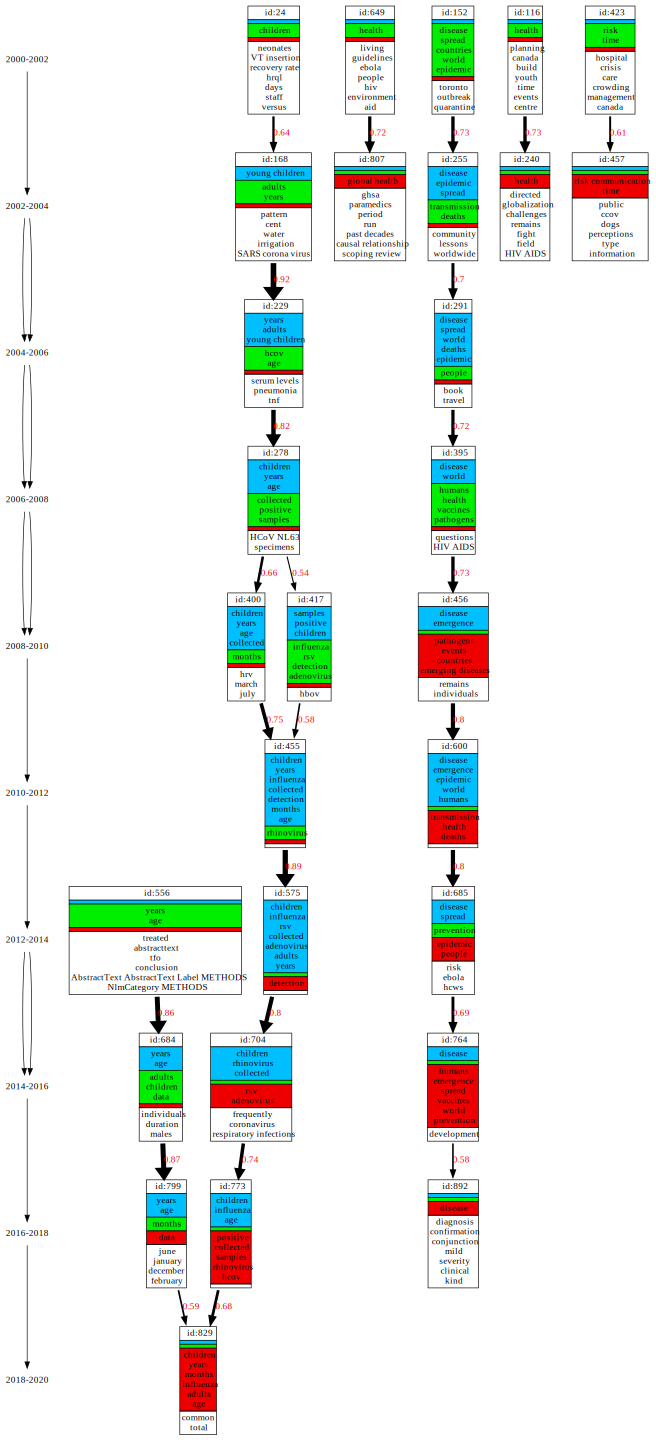

In [103]:
g1 = drawPivotGraph(beta, subgraphFuture, subgraphPast, periodList, labels)
g1.attr(size = '20')
g1.format = 'svg'
#g1.render('test-output/g1', view=True) 
#Source.from_file('test-output/g1')
g1